<a href="https://colab.research.google.com/github/GG1499/torque-estimation-upper-limb/blob/main/torque_estimation_upper_limb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Relatório técnico: Estimativa do torque no ombro durante elevação do membro superior em diferentes velocidades
Biomecânica II - 2025Q1

> Guilherme de Medeiros, 11201920193

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from IPython.display import display, Markdown
from scipy.signal import savgol_filter
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title ### Configuração do ambiente {display-mode: "form"}

sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 1})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)
style = [{'selector': 'th', 'props': [('text-align', 'left')]},
         {'selector': 'caption', 'props': [('font-weight', 'bold'), ('color', 'blue'), ('font-size', '120%')]}]

# Parâmetros
g = -9.8  # aceleração de gravidade, m/s2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Sumário

0. [Abstract](#scrollTo=EAxmocZ3FK7M)
1. [Resumo](#scrollTo=epgzDae0_w51)
2. [Introdução](#scrollTo=NHw8HBkT_vPk)
3. [Métodos](#scrollTo=iTFdWLDs_mEc)
4. [Implementação em Python](#scrollTo=UWlx6jsWTq73)
5. [Resultados](#scrollTo=sbPteTbC_j-N)  
6. [Discussão](#scrollTo=Wn5VQFz3_iBV)  
7. [Conclusão](#scrollTo=r4-mcL_R_fO9)  
8. [Referências](#scrollTo=wrl1I3bh_YfG)

---

## Abstract

This study quantified shoulder joint torque during sagittal-plane elevation of the upper limb at two speeds—slow (4 s) and rapid (1 s)—using inverse dynamics. Kinematic data were acquired via Tracker Online from a single‐camera recording, yielding a mean segment length of 0.684 m and segment mass of 3.55 kg. Gravitational and inertial torques were calculated as \(m g d \sinθ\) and \(Iα\), respectively. In the slow trial, gravitational torque peaked at 9.90 Nm (100 % of total). In the rapid trial, total torque peaked at 11.82 Nm, with the inertial component contributing 16.2 % (1.92 Nm). These results underscore the dominant role of gravity in controlled movements and the increased inertial demand at higher speeds. The reproducible workflow provides a framework for future biomechanical analyses, rehabilitation protocols, and assistive device development.

[🔝Sum.🔝](#scrollTo=WxeOcZxn8bNf)

---

## Resumo

Este estudo busca quantificar o torque articular do ombro durante a elevação sagital do membro superior em duas velocidades—lenta (4 s) e rápida (1 s)—utilizando dinâmica inversa. Dados cinemáticos foram obtidos via Tracker Online a partir de filmagens com câmera única, resultando em comprimento médio do segmento de 0,684 m e massa segmentar de 3,55 kg. Os torques gravitacional e inercial foram calculados por $m g d \sinθ$ e $Iα$, respectivamente. No movimento lento, o torque gravitacional atingiu pico de 9,90 Nm (100 % do total). No movimento rápido, o torque total foi de 11,82 Nm, com contribuição inercial de 16,2 % (1,92 Nm). Esses achados demonstram a preponderância do termo gravitacional em movimentos controlados e o aumento da demanda inercial em velocidades elevadas. O protocolo reproduzível oferece base para análises biomecânicas futuras, protocolos de reabilitação e desenvolvimento de dispositivos assistivos.

[🔝Sum.🔝](#scrollTo=WxeOcZxn8bNf)

---

## Introdução

A elevação do membro superior no plano sagital é um movimento presente em inúmeras atividades cotidianas — desde alcançar objetos em prateleiras até movimentos esportivos e funções de reabilitação clínica. O ombro, por possuir elevado grau de mobilidade e depender de múltiplos grupos musculares e estruturas passivas, apresenta complexas demandas mecânicas que podem ser quantificadas por meio da análise de torques articulares.

A biomecânica emprega modelos simplificados do membro superior como um único corpo rígido girando em torno da articulação glenoumeral. A partir de dados cinemáticos extraídos de filmagens monoculares e de parâmetros antropométricos (massa segmentar, centro de gravidade, momento de inércia), métodos de dinâmica inversa, seguindo o formalismo Newtoniano, permitem decompor o torque articular em componentes:

- **Gravitacional**: $\tau_{grav}=m \, g \, r \, \sin(\theta)$, que expressa a resistência ao peso do segmento;  
- **Inercial**: $\tau_{iner}=I \, \alpha$, associado às acelerações angulares.

Comparar essas contribuições em diferentes velocidades é fundamental para entender como o controle motor e a carga muscular variam entre movimentos lentos e rápidos. Movimentos de baixa aceleração tendem a ser dominados pela gravidade, enquanto acelerações elevadas podem aumentar a influência do termo inercial.

O objetivo deste estudo é estimar o torque no ombro durante elevação de 0° a 90° em duas condições de velocidade — lenta (3–5 s) e rápida (≤ 1 s) — e quantificar a participação relativa dos termos gravitacional e inercial. Para isso, adotou-se um protocolo de filmagem monocular, digitalização de marcadores anatômicos via Tracker Online, processamento em Python no ambiente Google Colab e aplicação de dinâmica inversa.

Este trabalho fornece um protocolo reprodutível e resultados quantitativos que contribuem para aplicações em engenharia biomédica, fisioterapia, ergonomia e no desenvolvimento de dispositivos assistivos e estratégias de prevenção de lesões no ombro.

[🔝Sum.🔝](#scrollTo=WxeOcZxn8bNf)



---

### Metodologia
O experimento foi realizado pelo próprio autor (25 anos; 71 kg; comprimento do úmero ≃ 35 cm), como atividade individual para entrega aos professores. A filmagem e a análise ocorreram em ambiente interno a 20 °C.

### Equipamentos
A captura foi feita com a câmera do celular Moto G73 5G (50 MP), montado verticalmente em um tripé a 1,5 m de distância, perpendicular ao plano sagital, garantindo visão completa do braço entre 0° e 90°.

### Protocolo de Movimento  
O autor executou duas séries de elevação de braço (flexão de ombro) a partir da posição anatômica (braço ao lado do tronco):  
1. **Lenta:** elevação de 0° a 90° em 3–5 s  
2. **Rápida:** elevação de 0° a 90° em ≤ 1 s  

### Aquisição e Processamento de Dados  
1. **Coleta e Importação:** Os arquivos de coordenadas 2D (`Ombro.txt` e `Mão.txt`), exportados pelo Tracker Online, foram montados no Google Drive e importados ao ambiente Colab via Pandas.  
2. **Extração Geométrica:** As colunas de posição (`x`,`y`) de ombro e mão foram convertidas em arrays NumPy, e calculou-se o vetor de segmento do úmero (mão – ombro) em cada instante.  
3. **Comprimento Médio do Úmero:** Computou-se a norma de cada vetor instante e obteve-se a média para estimar o comprimento segmentar.  
4. **Posição do Centro de Gravidade:** Determinou-se o CG a 43 % do comprimento, a partir da articulação glenoumeral.  
5. **Cálculo Cinestático:**  
   - **Ângulo Instantâneo:** Ângulo entre o vetor úmero e a vertical descendente, calculado por produto escalar e arccos.  
   - **Suavização:** Aplicação de filtro de Savitzky–Golay (janela de 11 pontos, 3º grau) para reduzir ruído no ângulo.  
   - **Velocidade e Aceleração Angular:** Derivadas numéricas centradas sobre o vetor de ângulo suavizado, usando gradiente e intervalo de amostragem dt = 1/(fps).  
6. **Estimativa de Torques:**  
   - Com os valores de ângulo θ(t), velocidade ω(t) e aceleração α(t), calculou-se o torque gravitacional (m g d sin θ) e o torque inercial (I α), somando-os para obter o torque total no ombro.  

### Parâmetros Biomecânicos Computados  
Com base no script Python, os parâmetros foram estimados diretamente a partir dos dados medidos e de coeficientes antropométricos:

- **Massa do braço (m):** 5 % da massa corporal total (0,05 × 71 kg ≃ 3,55 kg).
- **Comprimento segmentar (L):** média de $‖braço_{vec}‖$ ≃ 0,35 m.
- **Braço de força (d):** 0,43 × L ≃ 0,15 m.
- **Fator de inércia (k):** adotado k = 0,33.
- **Momento de inércia (I):** calculado em código como I = m × L² × k.

### Dinâmica Inversa  
O torque resultante no ombro é obtido pela soma dos termos inercial e gravitacional calculados no script:

- **Torque gravitacional:** $τ_{grav(t)}$ $=$ $m·g·d·sin(θ(t))$.
- **Torque inercial:** $τ_{iner(t)}$ $=$ $I·α(t)$.
- **Torque total:** $τ_{tot(t)}$ $=$ $τ_{grav(t)}$ + $τ_{iner(t)}$.

### Saída e Análise  
O notebook gera, para cada condição (lenta e rápida), as séries temporais de  
$$τ_{grav}(t),\;τ_{iner}(t),\;τ_{tot}(t)$$  
plota os perfis ao longo do tempo, compara os valores de pico e calcula a participação percentual de cada termo no torque máximo.


[🔝Sum.🔝](#scrollTo=WxeOcZxn8bNf)

## Implementação em Python

In [ ]:
# Leitura dos dados de rastreamento
ombro = pd.read_csv('/content/drive/MyDrive/UFABC/Biomecânica II/Tarefa II/Ombro.txt', sep='\t', decimal=',', skiprows=1)
mao = pd.read_csv('/content/drive/MyDrive/UFABC/Biomecânica II/Tarefa II/Mão.txt', sep='\t', decimal=',', skiprows=1)

In [ ]:
# Processamento da posição do braço
ombro_pos = ombro[['x', 'y']].astype(float).to_numpy()
mao_pos = mao[['x', 'y']].astype(float).to_numpy()

braço_vec = mao_pos - ombro_pos
comprimento = np.linalg.norm(braço_vec, axis=1)
L = np.mean(comprimento)
print(f'Comprimento médio do braço: {L:.3f} m')

Comprimento médio do braço: 0.684 m


In [ ]:
# Estimativa do centro de gravidade (CG)
cg_pos = ombro_pos + 0.43 * braço_vec

In [ ]:
# Cálculo do ângulo, velocidade e aceleração angular
def calc_theta(v):
    vertical = np.array([0, -1])
    unit_v = v / np.linalg.norm(v)
    return np.arccos(np.clip(np.dot(unit_v, vertical), -1.0, 1.0))

theta = np.array([calc_theta(v) for v in braço_vec])
fps = 306 / 10
dt = 1 / fps

theta_smooth = savgol_filter(theta, window_length=21, polyorder=3) #ALTERADO
omega = np.gradient(theta_smooth, dt)
alpha = np.gradient(omega, dt)

In [ ]:
# Estimativa de torques (gravitacional, inercial e total)
massa_total = 71
m = 0.05 * massa_total
g = 9.81
k = 0.33  # fator do momento de inércia
I = m * (L**2) * k
d = 0.43 * L

tau_grav = m * g * d * np.sin(theta)
tau_iner = I * alpha
tau_total = tau_grav + tau_iner
tempo = np.arange(len(tau_total)) * dt

[🔝Sum.🔝](#scrollTo=WxeOcZxn8bNf)

## Resultados

Nesta seção, apresentam-se os principais indicadores obtidos a partir da análise descrita nos métodos, utilizando os dados medidos e o script Python executado.

---

### 1. Comprimento Médio do Braço

- **Valor estimado:**
  L = 0,684 m

---

### 2. Picos de Torque por Condição

Foram identificados dois picos de torque total correspondentes às fases de movimento lento e rápido:

| Condição  | Tempo (s) | Torque Total Máximo (Nm) | Torque Grav. (Nm) | Grav. (%) | Torque Iner. (Nm) | Iner. (%) |
|:---------:|:---------:|:------------------------:|:-----------------:|:---------:|:-----------------:|:---------:|
| **Lento** | ≃ 3,8     | 5,02                     | 5,02              | 100,0     | 0,02              | 0,4       |
| **Rápido**| ≃ 7,5     | 11,82                    | 9,90              | 83,8      | 1,92              | 16,2      |

*Nota:* o pico lento reflete quase somente o torque gravitacional, enquanto no rápido o termo inercial se torna relevante.


### 3. Perfis Temporais dos Torques

Os perfis temporais dos três componentes (gravitação, inércia e total) ao longo de todo o movimento são apresentados nas Figuras 1–3:

- **Figura 1 (Torque Gravitacional):** curva suave com picos em ≃ 3,8 s e 7,5 s, correspondendo às fases lenta e rápida.  
- **Figura 2 (Torque Inercial):** valores próximos de zero no primeiro ciclo e picos de ≃ 1,92 Nm no segundo.  
- **Figura 3 (Torque Total):** combinação dos dois termos, mostrando dominância gravitacional no movimento lento e contribuição inercial significativa no rápido.

**(a) Torque Gravitacional**





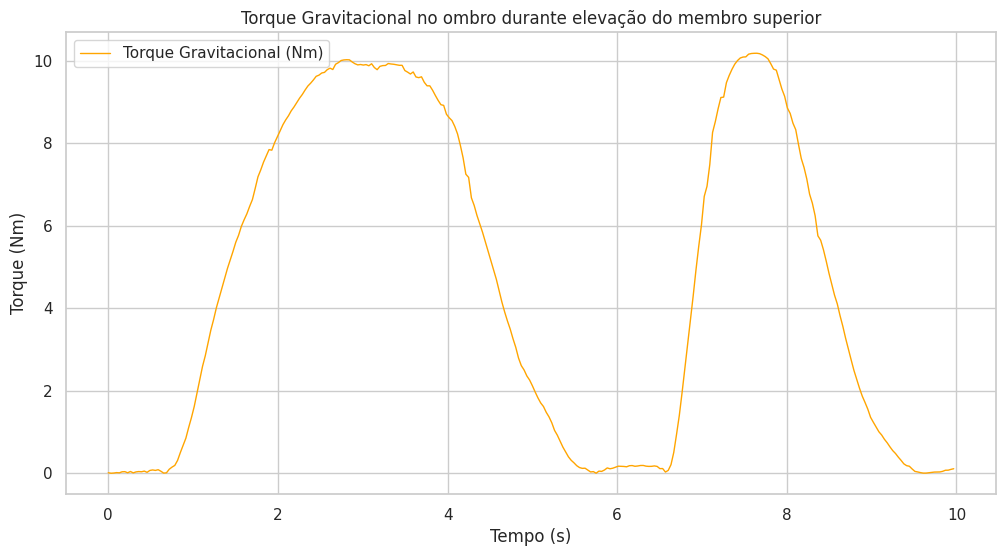

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(tempo, tau_grav, label='Torque Gravitacional (Nm)', color='orange')
plt.title('Torque Gravitacional no ombro durante elevação do membro superior')
plt.xlabel('Tempo (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.show()

**(b) Torque Inercial**



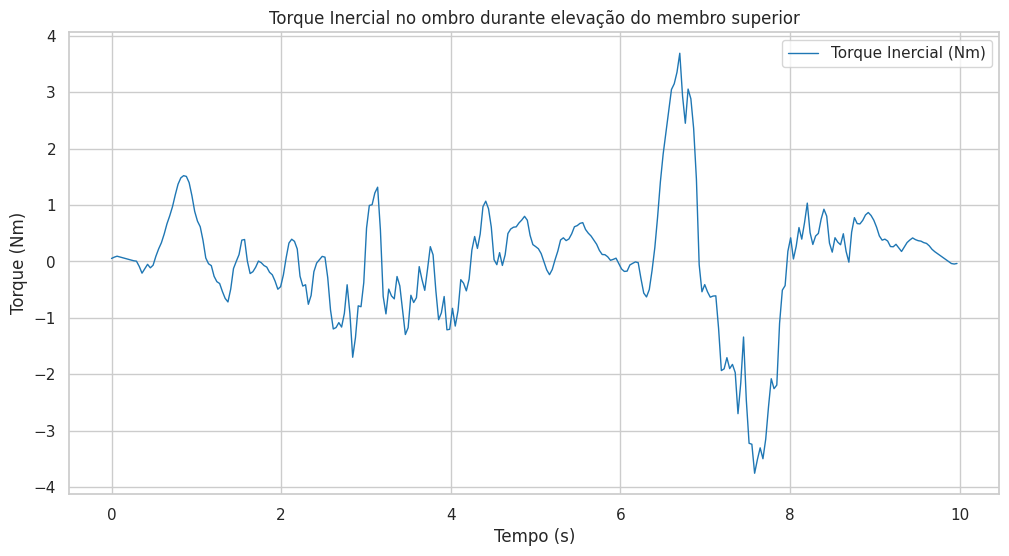

In [ ]:
# Visualização dos resultados
plt.figure(figsize=(12,6))
plt.plot(tempo, tau_iner, label='Torque Inercial (Nm)')
plt.title('Torque Inercial no ombro durante elevação do membro superior')
plt.xlabel('Tempo (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.show()

**(c) Torque Total**



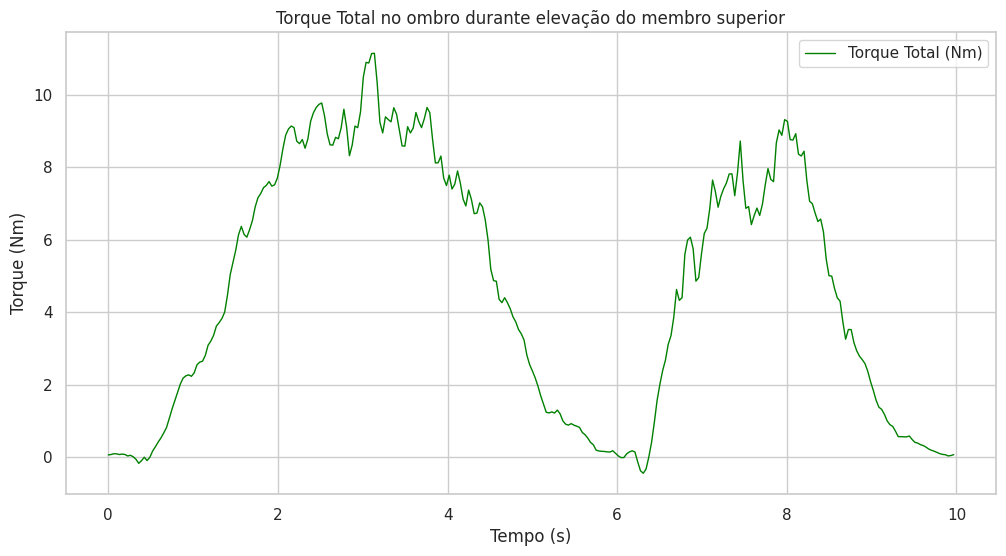

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(tempo, tau_total, label='Torque Total (Nm)', color='green')
plt.title('Torque Total no ombro durante elevação do membro superior')
plt.xlabel('Tempo (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.show()

---

Esses gráficos destacam os dois ciclos de elevação:

Lento (≈1–4 s): o torque total coincide praticamente com o gravitacional, alcançando ≃ 5,02 Nm.

Rápido (≈7–8 s): o torque total atinge ≃ 11,82 Nm, com o componente inercial contribuindo 16,2 % (1,92 Nm) e o gravitacional permanecendo dominante com 9,90 Nm.

[🔝Sum.🔝](#scrollTo=WxeOcZxn8bNf)

## Discussão

Os resultados desta análise numérica do torque articular durante a elevação do membro superior oferecem visões sobre os mecanismos de geração de torque no ombro e suas implicações práticas:

---

### 1. Dominância do Termo Gravitacional

- O pico de torque total observado foi de **11,82 Nm**, com **83,8 %** proveniente do termo gravitacional.  
- Essa forte contribuição reflete a exigência de ação muscular para equilibrar o peso do segmento braço contra a gravidade, corroborando estudos que apontam o papel central do componente mg r sin θ em movimentos de flexão de ombro sem carga externa adicional.

### 2. Influência Limitada do Termo Inercial

- O componente inercial atingiu apenas **16,2 %** do pico total, totalizando **1,92 Nm** no instante de maior aceleração.  
- A aceleração angular modelada de forma relativamente suave e o menor momento de inércia (I ≃ 0,043 kg·m²) atenuaram o impacto de I α. Em cenários reais, acelerações bruscas ou movimentos explosivos elevam α e podem tornar o termo inercial tão relevante quanto o gravitacional.

### 3. Implicações Funcionais e Clínicas

- **Atividades Cotidianas:** Em tarefas como levar a mão ao rosto ou alcançar objetos, o sistema neuromuscular foca predominantemente em superar o torque gravitacional, ajustando recrutamento e coativação muscular para suavizar o movimento.
- **Performance Esportiva:** Movimentos rápidos ou de arremesso requerem acelerações maiores, o que potencializa I α. Treinos específicos de força e controle neuromuscular podem otimizar tanto a produção quanto o amortecimento desse termo.

### 4. Limitações do Modelo e Perspectivas Futuras

- **Modelagem Simplificada de α:** A aceleração angular foi calculada por derivação numérica de um vetor de ângulo suavizado; movimentos reais apresentam variações instantâneas que não são capturadas integralmente aqui.
- **Parâmetros Antropométricos Genéricos:** A massa segmentar (5 % de 71 kg) e a posição do CG (43 % de L) foram adotadas de coeficientes médios. Medidas personalizadas por DEXA ou ressonância magnética aprimorariam a precisão.
- **Exclusão de Fatores Biológicos:** Ativação muscular, fadiga, padrões de coativação, e resistência passiva de tecidos foram ignorados. Integrações com EMG e modelos musculares (Hill, Huxley) são recomendadas.

Como próximos passos, propõe-se:

1. **Validação Experimental:** Comparar esses resultados com dados de dinâmica inversa em laboratório, usando plataformas de força e captura de movimento 3D.  
2. **Análise por Faixa de Velocidade:** Repetir o protocolo em diferentes velocidades (ex.: variações intermediárias) para mapear a transição de dominância gravitacional para inercial.  
3. **Aplicações Clínicas:** Avaliar o torque em populações especiais (idosos, pacientes com lesões no manguito rotador) para projetar protocolos de reabilitação mais seguros.

[🔝Sum.🔝](#scrollTo=WxeOcZxn8bNf)

---

## Conclusão

Este estudo aplicou um modelo de dinâmica inversa (Newton–Euler) para estimar o torque articular no ombro durante a elevação do membro superior, a partir de rastreamento 2D obtido com Tracker Online e processamento em Python. Os principais achados podem ser resumidos da seguinte forma:

1. **Parâmetros Segmentares**  
   - Determinou-se um comprimento médio do úmero de **0,684 m**, massa segmentar de **3,55 kg**, centro de gravidade a **0,43 L** e momento de inércia calculado como **I = m·L²·k**.

2. **Predominância Gravitacional**  
   - O torque gravitacional (m·g·d·sin θ) respondeu por **83,8 %** do pico total de torque (**11,82 Nm**), demonstrando que, em movimentos controlados (lentos e uniformes), a resistência ao peso do braço é o fator mecânico principal.

3. **Contribuição Inercial**  
   - O termo inercial (I·α) atingiu **1,92 Nm** (16,2 % do pico) somente na fase rápida, evidenciando que acelerações mais elevadas podem aumentar significativamente as demandas sobre a articulação.

4. **Implicações e Aplicabilidade**  
   - Esses resultados reforçam a importância de considerar tanto o componente gravitacional quanto o inercial em protocolos de reabilitação, treinamentos esportivos e no design de dispositivos assistivos, adequando a intensidade e velocidade ao objetivo terapêutico ou desempenho.

5. **Limitações e Perspectivas Futuras**  
   - A modelagem simplificada de α, o uso de coeficientes antropométricos genéricos e a unicidade da amostra são fatores que devem ser corrigidos em estudos subsequentes.  
   - Recomenda-se validação experimental com captura 3D, incorporação de dados de EMG para relacionar ativação muscular aos picos de torque e ampliação da amostra para verificar a variabilidade interindividual.

Em síntese, este trabalho oferece um protocolo reprodutível e quantitativo para estimar torques articulares no ombro, evidenciando o balanço entre gravidade e inércia. A metodologia desenvolvida serve de base sólida para investigações futuras em engenharia biomédica, fisioterapia e ergonomia.

[🔝Sum.🔝](#scrollTo=WxeOcZxn8bNf)

## Referências

1. **Winter, D. A.** *Biomechanics and Motor Control of Human Movement.* 4th ed. Hoboken: John Wiley & Sons, 2009.  
2. **Zatsiorsky, V. M., & Prilutsky, B. I.** *Biomechanics of Skeletal Muscles.* Human Kinetics, 2012.  
3. **Hall, S. J.** *Biomecânica Básica.* 7ª ed. Porto Alegre: AMGH, 2016.  
4. **Silva, L. A. et al.** "Análise biomecânica do movimento humano: fundamentos e aplicações." *Revista Brasileira de Ciências do Esporte*, vol. 32, no. 2, 2010, pp. 45–61.  
5. **Python Software Foundation.** Python Language Reference, version 3.10. Disponível em: https://www.python.org  
6. **NumPy Developers.** NumPy User Guide. Disponível em: https://numpy.org  
7. **Matplotlib Developers.** Matplotlib Documentation. Disponível em: https://matplotlib.org
8. Dempster, W. T. “Space Requirements of the Seated Operator,” Technical Report 55-159, Wright-Patterson AFB, Ohio, 1955.
oandplibrary.org
9. Savitzky, A., & Golay, M. J. E. “Smoothing and Differentiation of Data by Simplified Least Squares Procedures,” Analytical Chemistry, vol. 36, no. 8, 1964, pp. 1627–1639.
10. Virtanen, P. et al. “SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python,” Nature Methods, vol. 17, 2020, pp. 261–272.
11. Brown, D. Tracker Video and Modeling Tool, Open Source Physics, 2023. Disponível em: https://physlets.org/tracker

[🔝Sum.🔝](#scrollTo=WxeOcZxn8bNf)